In [ ]:
import requests
from fastdownload import download_url
from fastai.vision.all import show_image
from PIL import Image
from pathlib import Path
from fastai.vision.utils import download_images, verify_images, resize_images
from fastcore.all import L
from fastai.vision.all import * # type: ignore
from fastai.vision.widgets import *
from dotenv import load_dotenv
import os

load_dotenv()
PIXABAY_KEY = os.getenv("PIXABAY_API_KEY")


def search_pixabay(term, count=150, lang="en", image_type="photo"):
    """
    Search Pixabay for keyword images and return a FastAI-friendly list of URLs.
    """
    url = "https://pixabay.com/api/"
    params = {
        "key": PIXABAY_KEY,
        "q": term,
        "lang": lang,
        "image_type": image_type,
        "orientation": "all",
        "safesearch": "true",
        "order": "popular",
        "per_page": count
    }
    r = requests.get(url, params=params)
    if r.status_code != 200:
        print("Status:", r.status_code)
        print("Error:", r.text)
        r.raise_for_status()
    js = r.json()
    return L(item["largeImageURL"] for item in js.get("hits", []) if "largeImageURL" in item)

# 🔎 Example usage
results = search_pixabay("Domestic Shorthair", count=150)
print(len(results), "images found")
print(results[:3])


150 images found
['https://pixabay.com/get/g9cca78922a3e4a47cde2f2f4953e4464d01eacf2126054c6ebc1303172917057cd200e4e6abc1b6d12baa9c272333d0258129d899cb73cfad6257b956726b94b_1280.jpg', 'https://pixabay.com/get/gfcdc43278739ffb04670fffa7cb3c183b79294108b6c6bf1e5f24539e63026ba0527ecabff8e061cb83a1f7efe39fa840a6b8ca5aab4fdc3b0ea61522cc91484_1280.jpg', 'https://pixabay.com/get/g60b72e056047c65b9148c4cc61714063d00861427f99563ebe6541937d98621d4aba1eac935f38311a820c802e8296cfb18eefb76396220465b6bde9ee006a8b_1280.jpg']


In [2]:
ims = results.attrgot('contentUrl')
len(ims)

150

In [3]:
ims = ['https://pixabay.com/get/gbe0941abc94e5cbae99bffde5f586ecb6eb697bd313a7e25377615c5ab24128d1752ed378f25b9dd0692e06535c6f4ad73a973dba1c2758b4a91b1c7a42de167_1280.jpg']

In [4]:
dest = 'images/cats.jpg'
download_url(ims[0], dest)

Path('images/cats.jpg')

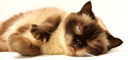

In [5]:
im = Image.open(dest)
im.to_thumb(128,128) # type: ignore

In [6]:
cat_types = 'domestic shorthair', 'domestic longhair','siamese'
path = Path('cats')

In [7]:
path.mkdir(parents=True, exist_ok=True)
for o in cat_types:
    dest = path/o
    dest.mkdir(exist_ok=True)
    results = search_pixabay(f'{o} cat', count=80)
    download_images(dest, urls=list(results))

In [8]:
fns = get_image_files(path)
fns

(#180) [Path('cats/domestic longhair/0219d63b-74b4-467b-a584-55b985fc26e6.jpg'),Path('cats/domestic longhair/026c1e1c-cd76-4bb1-88bf-9ddd386a83a8.jpg'),Path('cats/domestic longhair/04977ff8-e279-4660-be46-bb1c87dad002.jpg'),Path('cats/domestic longhair/0608e4c7-ed47-4332-bd80-956e4d6f18b7.jpg'),Path('cats/domestic longhair/09704307-b2df-4981-838e-2e93c2c84df5.jpg'),Path('cats/domestic longhair/0e8566a8-e982-43f3-a6e2-28f615e44a3f.jpg'),Path('cats/domestic longhair/158f9404-7bf0-4c21-80d7-3668c74eeb07.jpg'),Path('cats/domestic longhair/16644fdc-917f-46a7-8477-c9ccf2aef762.jpg'),Path('cats/domestic longhair/1b19053e-3472-42b1-9d4f-02fadea69458.jpg'),Path('cats/domestic longhair/1dde36e7-2f1d-4b9c-b9ad-90e6ca669a5d.jpg'),Path('cats/domestic longhair/231f38b5-5450-44af-9320-881b98497525.jpg'),Path('cats/domestic longhair/2355ffac-510a-4fdd-99fd-c21039078799.jpg'),Path('cats/domestic longhair/32c44ecf-2a8e-45f9-a840-313044d645b1.png'),Path('cats/domestic longhair/36e14e12-d44e-44a3-b975-134

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
failed.map(Path.unlink)

(#0) []

In [11]:
# Dataloaders are a thin calss that just stores what Objects you pass to it and makes them available as train and valid. 
class DataLoaders(GetAttr):
    def _init_(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train, valid = add_props(lambda i, self: self[i])

In [12]:
# First we provided a tuple where we specify what types we want for the independent and dependent variables: blocks = (ImageBlock, CategoryBlock)
# independent variables is what we are using to make predictions from and dependent variable is our target
from fastai.vision.all import *

cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

In [13]:
dls = cats.dataloaders(path)

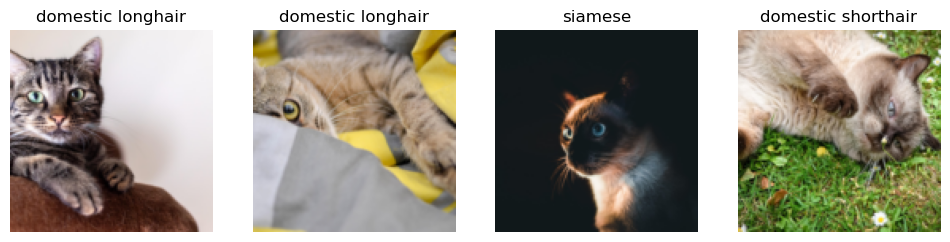

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

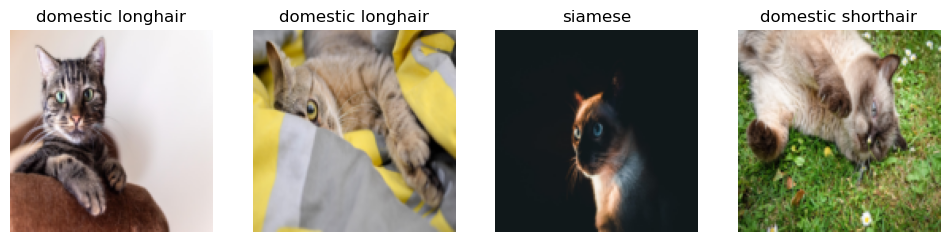

In [15]:
cat_types = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


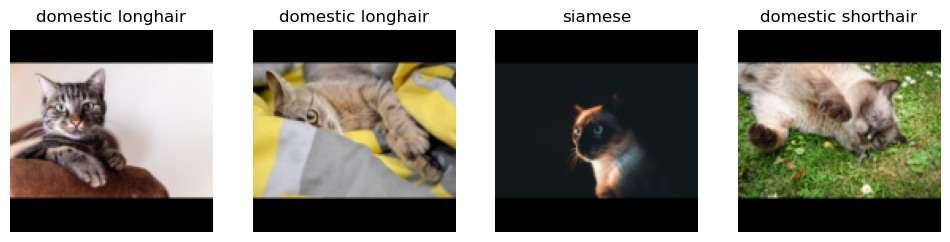

In [16]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

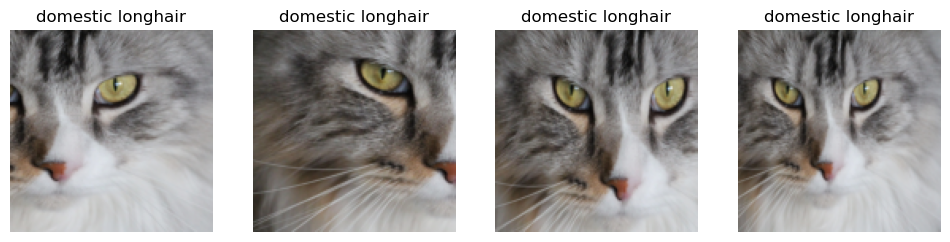

In [17]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

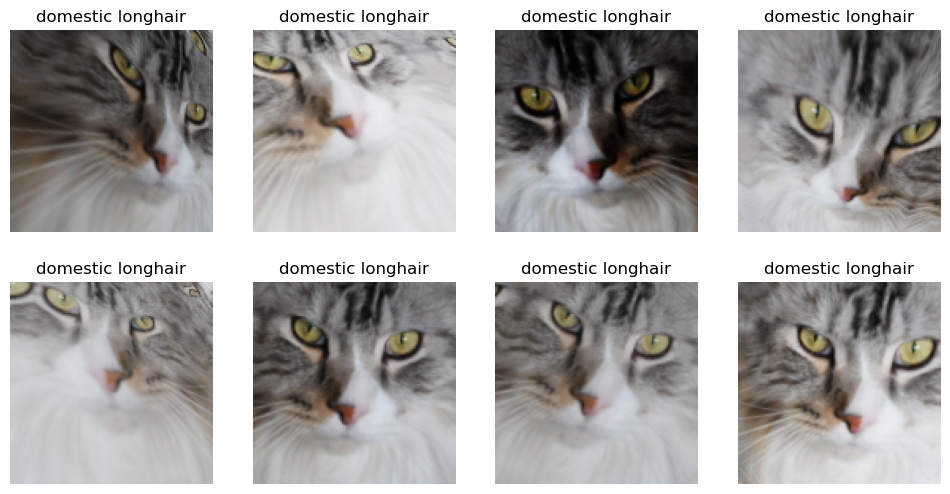

In [18]:
# Data augmentation can refer to creating random variations of our input data so they appear different. I.e image rotation, flipping, perspective warping, brightness changes and contrast changes
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
# Training our model and using to clena the data
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

In [20]:
# create our Learner and fine-tune it
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.806157,1.552249,0.500000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.433336,1.153973,0.444444,00:01
1,1.341666,1.007631,0.333333,00:01
2,1.175847,1.052284,0.361111,00:01
3,1.063552,1.092219,0.361111,00:01


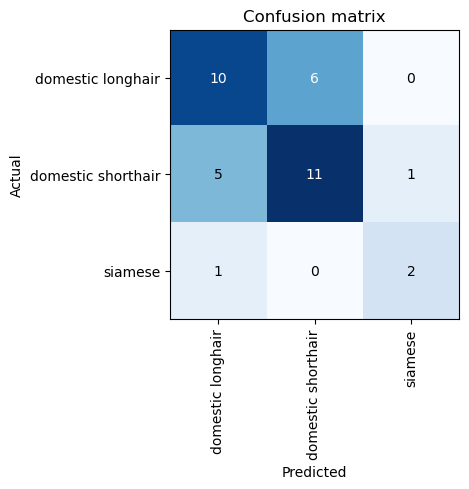

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

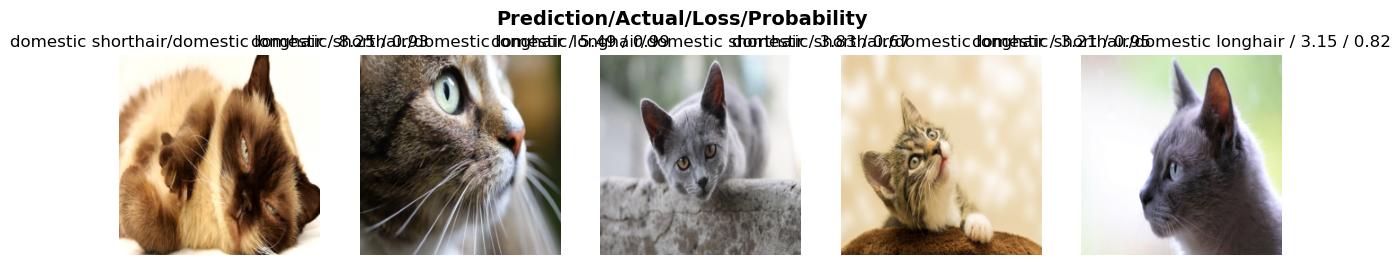

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
# Creating our inference learner from the exported file
learn_inf = load_learner(path/'export.pkl')

d:\miniforge\envs\ml-nlp\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [28]:
# Returns 3 things: the pridcited category in the same format we originally provided(string), index of the predicted caegory, probabilites of each category
learn_inf.predict('images/cats.jpg')

('domestic shorthair', tensor(1), tensor([2.6171e-04, 9.2545e-01, 7.4289e-02]))

In [29]:
learn_inf.dls.vocab

['domestic longhair', 'domestic shorthair', 'siamese']

In [30]:
# Gui input
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [31]:
btn_upload = SimpleNamespace(data = ['images/cats.jpg'])

In [32]:
img = PILImage.create(btn_upload.data[-1])

In [33]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
pred, pred_idx, probs = learn_inf.predict(img)

In [35]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Predicition: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predicition: domestic shorthair; Probability: 0.9254')

In [36]:
from duckdb import description


btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [38]:
btn_upload = widgets.FileUpload()

In [39]:
VBox([widgets.Label('Select your cats'),
      btn_upload, btn_run, out_pl, lbl_pred])